In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import nltk
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [2]:
# Functions to visualize word vector information
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    #tfidf_means = np.nanmean(np.where(matrix!=0,matrix,np.nan),1)
    #tfidf_means = np.mean(D, axis=0)
    tfidf_means = np.sum(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)          
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df        
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [3]:
# Hamming score
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [4]:
# Get data to work with

from observatorio_laboral.offer.offer_controller import OfferController
from observatorio_laboral.offer.date_range import DateRange

text_fields = []
oc = OfferController(text_fields = ["Job Title", "Description", "Qualifications", "Software"], table="train_offers")
date_range = DateRange(1, 2013, 5, 2017)
source = "symplicity"

# Get offers by date range
oc.load_offers(source, date_range)
print("Nro de conv. en la fecha ingresada: ", len(oc.offers))

# Get offers by career
oc.filter_offers_by_career("ECONOMÍA")
print("Nro de conv. de la carrera: ", len(oc.offers))

# Get labeled offers
oc.filter_offers_by_field("Areas")
print("Nro de conv. clasificadas: ", len(oc.offers))

Nro de conv. en la fecha ingresada:  553
Nro de conv. de la carrera:  553
Nro de conv. clasificadas:  553


In [5]:
# Optional: Ignore some classes
offer_classes = oc.get_field_labels("Areas", ignore=['TE', 'MC', 'OI', 'EI', 'EM'])

# Simple text preprocesing
offer_texts = oc.get_text()
punctuations = ['•','/', ')', '-']
translator = str.maketrans("".join(punctuations),' '*len(punctuations))

proc_data = []
for text in offer_texts:
    text = text.lower()
    text = text.translate(translator)
    proc_data.append(text)
    
offer_texts = proc_data

X = offer_texts
y = offer_classes

# Load reviewed vocabulary
vocab = set()
with open("diccionarioEconomia.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        word = row['Concepto']
        mark = row['Economía']
        
        if mark == 's':
            vocab.add(word)
            
vocab = list(vocab)
print("Tamaño del vocabulario: ", len(vocab))

Tamaño del vocabulario:  3254


In [6]:
# Transform labels to 0/1 arrays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
mlb = MultiLabelBinarizer().fit(y)
y_train_binary = mlb.transform(y_train)
y_test_binary = mlb.transform(y_test)

print("Train shape: ", y_train_binary.shape)
print("Test shape: ", y_test_binary.shape)

Train shape:  (414, 2)
Test shape:  (139, 2)


In [20]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from time import time

vectorizers = [TfidfVectorizer(tokenizer=None, ngram_range=(1,3), stop_words=None, vocabulary=vocab),               
               #CountVectorizer(tokenizer=None),
              ]

feature_selectors = [SelectKBest(chi2, k=1000),
                     SelectFromModel(OneVsRestClassifier(LinearSVC(penalty="l1", dual=False, tol=1e-3))), 
                    ]

classifiers = [LinearSVC(),
               RandomForestClassifier(),
               MultinomialNB(),
               BernoulliNB(),               
               #SGDClassifier(),
              ]

parameters = {
    #'vec__max_df' : (0.5, 0.75, 1.0),
    #'vec__min_df' : (0.0, 0.05, 0.01),
    #'vec__ngram_range' : ((1,1), (1,2), (1,3)),
    #'vec__vocabulary' : (None, vocab),    
    #'vec__use_idf' : (False, True),
    #'vec__norm' : (None, 'l2'),
    #'vec__binary' : (True, False),    
    #'vec__tokenizer' : (None, word_tokenize),
    #'vec__stop_words' : (None, stopwords.words('spanish')),
    #'fs__k' : (1000,),    
}


for vectorizer in vectorizers:
    vec = ('vec', vectorizer)
    for feature_selector in feature_selectors:
        fs = ('fs', feature_selector)
        for classifier in classifiers:
            custom_parameters = {}
            if isinstance(classifier, RandomForestClassifier):
                clf = classifier
            elif isinstance(classifier, LinearSVC):
                clf = OneVsRestClassifier(classifier)
                custom_parameters = {'clf__estimator__class_weight' : (None, 'balanced'),
                                     #'clf__estimator__C': [1, 10, 100, 1000],
                                    }
                
            else:
                clf = OneVsRestClassifier(classifier)
                
            clf = ('clf', clf)
            
            pipeline = Pipeline([vec, fs, clf])
            
            # Add to dictionaries without altering them
            all_params = {**parameters, **custom_parameters}
            
            grid_search = GridSearchCV(pipeline, all_params,
                                       scoring=make_scorer(hamming_score), n_jobs=-1, cv=5)
            
            
            
            print("Pipeline: ")
            print(vectorizer.__class__)
            print(feature_selector.__class__)
            print(classifier.__class__)
            
            t0 = time()
            grid_search.fit(X_train, y_train_binary)
            print([features[i] for i in grid_search.best_estimator_.steps[1][1].get_support(indices=True)])
            print("done in %0.3fs" % (time() - t0))
            print()
            
            print("Best F1-micro score: %0.3f" % grid_search.best_score_)            
                        
            y_pred_binary = grid_search.predict(X_test)
            print("Metrics :")            
            print("Accuracy: %0.3f" %  accuracy_score(y_test_binary, y_pred_binary))
            print("F1-micro: %0.3f" %  f1_score(y_test_binary, y_pred_binary, average='micro'))
            print("F1-macro: %0.3f" %  f1_score(y_test_binary, y_pred_binary, average='macro'))            
            print("Hamming: %0.3f" %  hamming_score(y_test_binary, y_pred_binary))
            
            print()            
            
            print("Best parameters set:")            
            best_parameters = grid_search.best_estimator_.get_params()
            for param_name in sorted(all_params.keys()):
                if param_name == "vec__stop_words":
                    if best_parameters[param_name] == None:
                        print("\t%s: None" % (param_name))
                    else:
                        print("\t%s: spanish" % (param_name))
                elif param_name == "vec__vocabulary":
                    if best_parameters[param_name] == None:
                        print("\t%s: Default" % (param_name))
                    else:
                        print("\t%s: Reviewed" % (param_name))
                else:
                    print("\t%s: %r" % (param_name, best_parameters[param_name]))            
            print("================================================================")
            print()

                

Pipeline: 
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
<class 'sklearn.feature_selection.univariate_selection.SelectKBest'>
<class 'sklearn.svm.classes.LinearSVC'>


NameError: name 'features' is not defined

In [121]:
for word in vocab:
    if (len(word.split()) == 3):
        print(word)

rubro de banca
proceso de integración
manejo del inglés
interpretación de información
conocimientos de estrategias
proyección de estados
búsqueda de información
maestría en administración
preparación de documentos
trabajos de investigación
objetivos de ventas
posición de jefe
cuota de mercado
administración de riesgos
reportes en excel
plan de auditoría
área de contabilidad
políticas de créditos
análisis de presupuestos
medición de resultados
áreas de banca
indicadores de ventas
resolución de problemas
pérdida de ingresos
cadena de suministro
cartas de crédito
optimización de procesos
dirección y gestión
manejo del sap
eficacia y eficiencia
elaboración del reporte
área de finanzas
valuación de instrumentos
revisión de procesos
costo y preparación
analista de productos
excel y word
valorización de empresas
evaluación de cambio
análisis de flujos
desarrollo del plan
clasificación de riesgo
asistente de tesorería
fondos de pensiones
indicadores de venta
cumplimiento de indicadores
conocim

/home/howl/.virtualenvs/Observatorio-Laboral/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


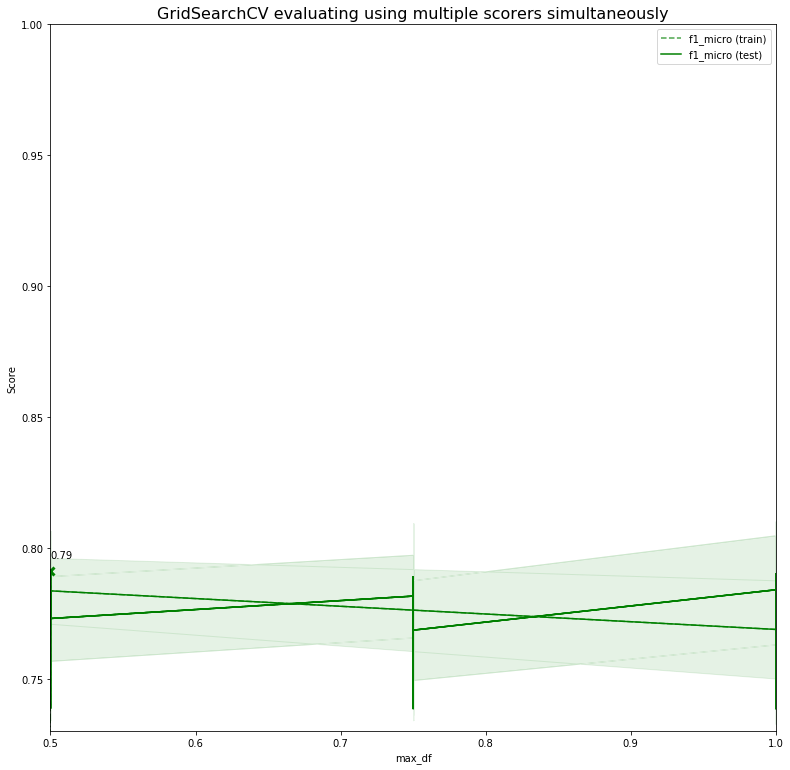

In [93]:
results = grid_search.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_df")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0.5, 1)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_vec__max_df'].data, dtype=float)
scoring = {'f1_micro' : 'f1_micro'}

for scorer, color in zip(sorted(scoring), ['g']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_test_score']
        sample_score_std = results['std_test_score']
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
    best_score = results['mean_test_score'][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()
